# XAI Group Project

Link to dataset: https://www.openml.org/search?type=data&status=active&id=31&sort=runs


In [19]:
# Import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [20]:
# Only enable when using Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [21]:
from scipy.io.arff import loadarff

# Martijn's path: /content/drive/Shareddrives/Martijn/xAI course/dataset_31_credit-g.arff
raw_data = loadarff("dataset_31_credit-g.arff")
df = pd.DataFrame(raw_data[0])

df.head(5)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,b'<0',6.0,b'critical/other existing credit',b'radio/tv',1169.0,b'no known savings',b'>=7',4.0,b'male single',b'none',...,b'real estate',67.0,b'none',b'own',2.0,b'skilled',1.0,b'yes',b'yes',b'good'
1,b'0<=X<200',48.0,b'existing paid',b'radio/tv',5951.0,b'<100',b'1<=X<4',2.0,b'female div/dep/mar',b'none',...,b'real estate',22.0,b'none',b'own',1.0,b'skilled',1.0,b'none',b'yes',b'bad'
2,b'no checking',12.0,b'critical/other existing credit',b'education',2096.0,b'<100',b'4<=X<7',2.0,b'male single',b'none',...,b'real estate',49.0,b'none',b'own',1.0,b'unskilled resident',2.0,b'none',b'yes',b'good'
3,b'<0',42.0,b'existing paid',b'furniture/equipment',7882.0,b'<100',b'4<=X<7',2.0,b'male single',b'guarantor',...,b'life insurance',45.0,b'none',b'for free',1.0,b'skilled',2.0,b'none',b'yes',b'good'
4,b'<0',24.0,b'delayed previously',b'new car',4870.0,b'<100',b'1<=X<4',3.0,b'male single',b'none',...,b'no known property',53.0,b'none',b'for free',2.0,b'skilled',2.0,b'none',b'yes',b'bad'


In [22]:
# Some columns are of data type "byte" --> convert them to strings
for col, dtype in df.dtypes.items():
    if dtype == object:  # Only process byte object columns.
        df[col] = df[col].apply(lambda x: x.decode("utf-8"))

In [23]:
# Generate basic info on categorical variables
for col in df.columns[df.dtypes == object]:
    print(f"{df[col].value_counts()}\n")

checking_status
no checking    394
<0             274
0<=X<200       269
>=200           63
Name: count, dtype: int64

credit_history
existing paid                     530
critical/other existing credit    293
delayed previously                 88
all paid                           49
no credits/all paid                40
Name: count, dtype: int64

purpose
radio/tv               280
new car                234
furniture/equipment    181
used car               103
business                97
education               50
repairs                 22
domestic appliance      12
other                   12
retraining               9
Name: count, dtype: int64

savings_status
<100                603
no known savings    183
100<=X<500          103
500<=X<1000          63
>=1000               48
Name: count, dtype: int64

employment
1<=X<4        339
>=7           253
4<=X<7        174
<1            172
unemployed     62
Name: count, dtype: int64

personal_status
male single           548
female div/d

In [24]:
# Generate basic info on numerical variables
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [25]:
X = df.drop('class', axis=1)
X = X.drop(columns=["savings_status", "property_magnitude"]) # TODO: Remove once missing value imputation is done
y = df['class']

In [26]:
def convert_to_dummies(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            dummy_columns = pd.get_dummies(df[column], prefix=column, drop_first=True)
            df = pd.concat([df, dummy_columns], axis=1)
            df = df.drop(column, axis=1)
    return df

X_prime = convert_to_dummies(X)
X_prime

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status_<0,checking_status_>=200,checking_status_no checking,...,other_parties_none,other_payment_plans_none,other_payment_plans_stores,housing_own,housing_rent,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_yes,foreign_worker_yes
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,True,False,False,...,True,True,False,True,False,True,False,False,True,True
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,False,False,False,...,True,True,False,True,False,True,False,False,False,True
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,False,False,True,...,True,True,False,True,False,False,False,True,False,True
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,True,False,False,...,False,True,False,False,False,True,False,False,False,True
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,True,False,False,...,True,True,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,31.0,1.0,1.0,False,False,True,...,True,True,False,True,False,False,False,True,False,True
996,30.0,3857.0,4.0,4.0,40.0,1.0,1.0,True,False,False,...,True,True,False,True,False,False,False,False,True,True
997,12.0,804.0,4.0,4.0,38.0,1.0,1.0,False,False,True,...,True,True,False,True,False,True,False,False,False,True
998,45.0,1845.0,4.0,4.0,23.0,1.0,1.0,True,False,False,...,True,True,False,False,False,True,False,False,True,True


In [27]:
# Define sample weights
# This enables us to use the custom cost matrix:
#
#      Good  Bad
# Good   0    5
# Bad    1    0
#
# Columns = true class & rows = predicted class

sample_weights = y.apply(lambda x: 5 if x == "bad" else 1)

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


def evaluate_classifier(y_true, y_pred, weights, metrics):
    # Confusion matrix (without sample weights!)
    metrics["confusion"].append(
        confusion_matrix(y_true, y_pred, labels=["good", "bad"])
    )
    
    # Precision score
    metrics["precision"].append(
        precision_score(y_true, y_pred, pos_label="good", sample_weight=weights)
    )
    
    # Recall score
    metrics["recall"].append(
        recall_score(y_true, y_pred, pos_label="good", sample_weight=weights)
    )
    
    # F1-score
    metrics["f1"].append(
        f1_score(y_true, y_pred, pos_label="good", sample_weight=weights)
    )
    
    # Specificity score
    tp, fn, fp, tn = confusion_matrix(y_true, y_pred, labels=["good", "bad"], sample_weight=weights).ravel() # Only works in this way for non-transposed cm and binary problems
    metrics["specificity"].append(tn / (tn+fp))


def aggregate_metrics(metrics):
    for metric in metrics:
        if metric == "confusion":
            mean_cm = np.mean(metrics["confusion"], axis=0)
            metrics["confusion"] = mean_cm / np.sum(mean_cm) # Normalization
        else:
            metrics[metric] = f"{np.mean(metrics[metric]):.3f} +- {np.std(metrics[metric]):.3f}"



In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

evaluations = []
random_state = 21

for max_depth in range(2, X_prime.shape[1]):
    metrics_train = {"confusion": [], "precision": [], "recall": [], "f1": [], "specificity": []}
    metrics_test = {"confusion": [], "precision": [], "recall": [], "f1": [], "specificity": []}

    # Stratified k-fold cross-validation on a Random Forest classifier using the custom cost matrix
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # Define train and test set
        X_train = X_prime.iloc[train_index]
        y_train = y.iloc[train_index]
        weights_train = sample_weights.iloc[train_index]

        X_test = X_prime.iloc[test_index]
        y_test = y.iloc[test_index]
        weights_test = sample_weights.iloc[test_index]
        
        # Train classifier
        clf = RandomForestClassifier(max_depth=max_depth, class_weight={"good": 1, "bad": 5}, random_state=random_state).fit(X_train, y_train)
        
        # Evaluate classifier
        evaluate_classifier(y_train, clf.predict(X_train), weights_train, metrics_train)
        evaluate_classifier(y_test, clf.predict(X_test), weights_test, metrics_test)
    
    # Aggregate metrics
    aggregate_metrics(metrics_train)
    aggregate_metrics(metrics_test)
    
    # Store metrics
    evaluations.append([
        max_depth,
        metrics_train["precision"], metrics_train["recall"], metrics_train["f1"], metrics_train["specificity"], metrics_train["confusion"],
        metrics_test["precision"], metrics_test["recall"], metrics_test["f1"], metrics_test["specificity"], metrics_test["confusion"]
    ])

evaluations = pd.DataFrame(evaluations, columns=["max_depth",
                                                 "train_precision", "train_recall", "train_f1", "train_specificity", "train_confusion",
                                                 "test_precision", "test_recall", "test_f1", "test_specificity", "test_confusion"])
evaluations

,max_depth,train_precision,train_recall,train_f1,train_specificity,train_confusion,test_precision,test_recall,test_f1,test_specificity,test_confusion
0,2,1.000 +- 0.000,0.043 +- 0.016,0.082 +- 0.029,1.000 +- 0.000,"[[0.03, 0.67], [0.0, 0.3]]",1.000 +- 0.000,0.033 +- 0.010,0.063 +- 0.019,1.000 +- 0.000,"[[0.023, 0.677], [0.0, 0.3]]"
1,3,0.968 +- 0.035,0.204 +- 0.006,0.337 +- 0.007,0.997 +- 0.004,"[[0.14266666666666666, 0.5573333333333333], [0...",0.863 +- 0.115,0.201 +- 0.023,0.325 +- 0.033,0.983 +- 0.015,"[[0.141, 0.559], [0.005, 0.295]]"
2,4,0.954 +- 0.014,0.389 +- 0.016,0.552 +- 0.014,0.991 +- 0.003,"[[0.272, 0.428], [0.0026666666666666666, 0.297...",0.800 +- 0.074,0.347 +- 0.023,0.482 +- 0.013,0.957 +- 0.020,"[[0.243, 0.457], [0.013, 0.287]]"
3,5,0.936 +- 0.008,0.520 +- 0.011,0.669 +- 0.011,0.983 +- 0.002,"[[0.36433333333333334, 0.33566666666666667], [...",0.700 +- 0.019,0.464 +- 0.035,0.557 +- 0.022,0.907 +- 0.013,"[[0.325, 0.375], [0.028, 0.272]]"
4,6,0.927 +- 0.025,0.629 +- 0.012,0.749 +- 0.014,0.977 +- 0.009,"[[0.44, 0.26], [0.007, 0.293]]",0.662 +- 0.057,0.543 +- 0.028,0.594 +- 0.014,0.867 +- 0.037,"[[0.38, 0.32], [0.04, 0.26]]"
5,7,0.953 +- 0.022,0.711 +- 0.008,0.814 +- 0.009,0.983 +- 0.008,"[[0.49766666666666665, 0.20233333333333334], [...",0.607 +- 0.044,0.626 +- 0.032,0.614 +- 0.012,0.807 +- 0.043,"[[0.438, 0.262], [0.058, 0.242]]"
6,8,0.968 +- 0.014,0.788 +- 0.019,0.869 +- 0.008,0.988 +- 0.006,"[[0.5516666666666666, 0.14833333333333334], [0...",0.545 +- 0.048,0.681 +- 0.022,0.604 +- 0.033,0.730 +- 0.049,"[[0.477, 0.223], [0.081, 0.219]]"
7,9,0.989 +- 0.011,0.860 +- 0.016,0.920 +- 0.008,0.996 +- 0.004,"[[0.6023333333333334, 0.09766666666666667], [0...",0.506 +- 0.034,0.740 +- 0.017,0.600 +- 0.025,0.660 +- 0.047,"[[0.518, 0.182], [0.102, 0.198]]"
8,10,0.992 +- 0.004,0.916 +- 0.015,0.953 +- 0.009,0.997 +- 0.002,"[[0.6413333333333333, 0.058666666666666666], [...",0.459 +- 0.036,0.767 +- 0.024,0.574 +- 0.027,0.573 +- 0.067,"[[0.537, 0.163], [0.128, 0.172]]"
9,11,0.998 +- 0.004,0.960 +- 0.013,0.978 +- 0.007,0.999 +- 0.002,"[[0.6716666666666666, 0.028333333333333332], [...",0.459 +- 0.030,0.811 +- 0.026,0.586 +- 0.024,0.550 +- 0.055,"[[0.568, 0.132], [0.135, 0.165]]"


In [ ]:
# Analysing the performance of the Naive Classifier

# Distribution of the target variable:
# - 700 "good" instances (70%)
# - 300 "bad" instances  (30%)

# Assuming stratified 5-fold cross validation:
# - Each iteration yields a Naive Classifier that always outputs "good"
# - Each fold contains:
#   * 700 / 5 = 140 "good" instances
#   * 300 / 5 = 60 "bad" instances
# - Thus, each iteration yields the following confusion matrix on the test set:
#   * TP = 140
#   * FP = 60
#   * TN = FN = 0
# - Applying the custom cost matrix to this confusion matrix results in:
#   * TP = 140
#   * FP = 300
#   * TN = FN = 0
# - Thus, each iteration yields the following metrics:
#   * precision = 140 / (140 + 300) = 140 / 440 = .318
#   * recall = 140 / (140 + 0) = 140 / 140 = 1.000
#   * f1 = (2 * .318 * 1.000) / (.318 + 1.000) = .636 / 1.318 = .483
# - Mean of these metrics over all folds is equal to the numbers above and the standard deviations are all 0

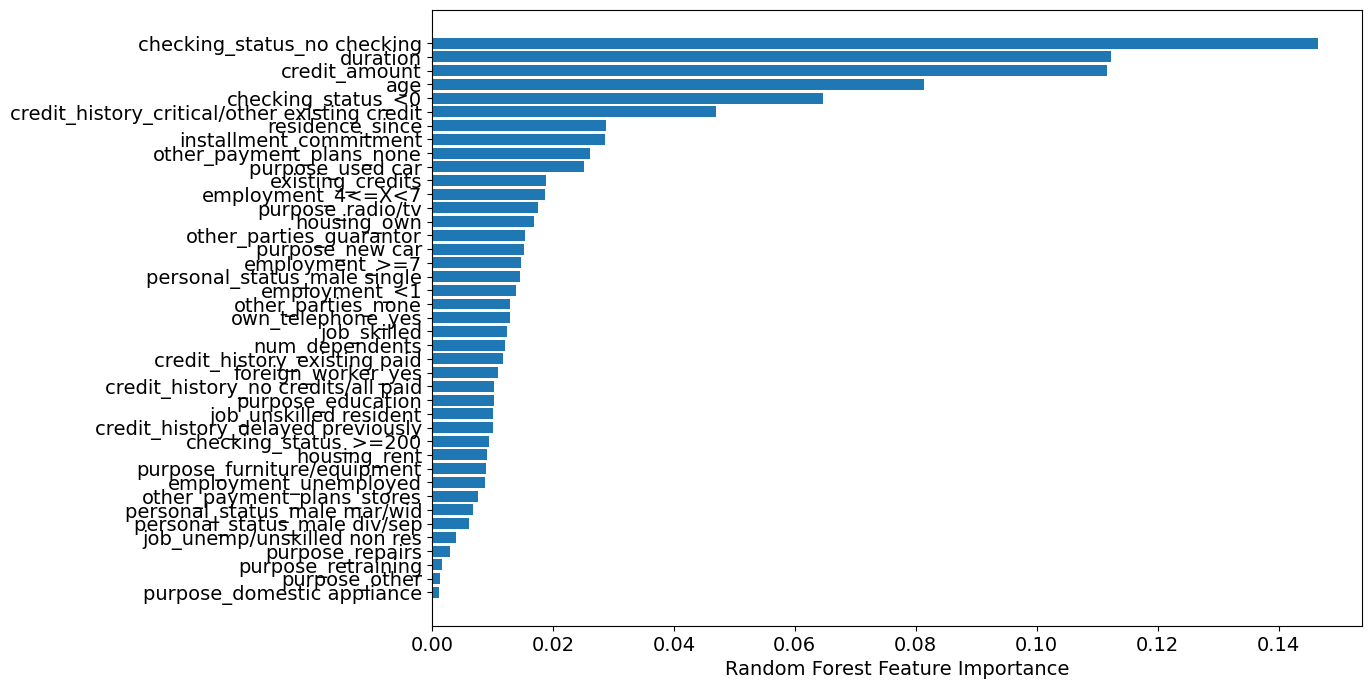

In [33]:
clf = RandomForestClassifier(max_depth=7, class_weight={"good": 1, "bad": 5}, random_state=random_state).fit(X_prime, y)

sorted_idx = clf.feature_importances_.argsort()
features_list = X_prime.columns.values
plt.barh(features_list[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

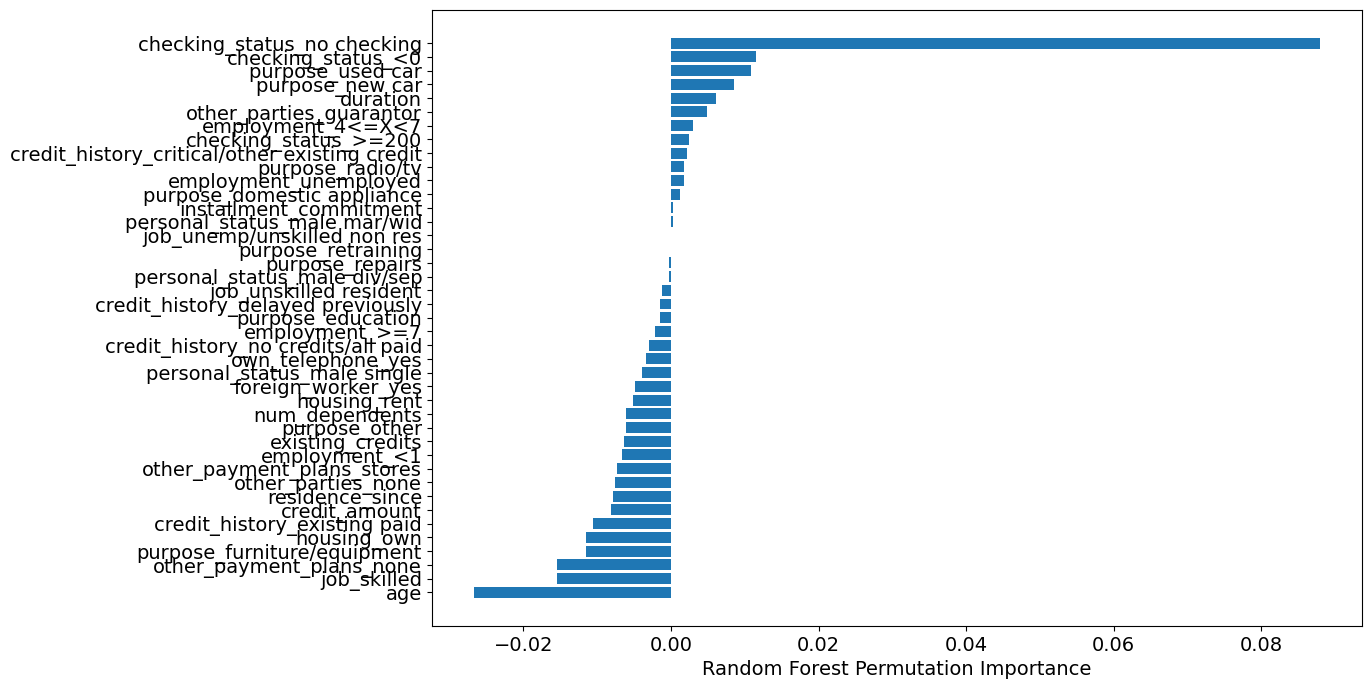

In [35]:
from sklearn.model_selection import train_test_split

# Permutation feature importance scores for each feature
X_train, X_test, y_train, y_test = train_test_split(X_prime, y, test_size=.3, random_state=random_state, stratify=y)
clf = RandomForestClassifier(max_depth=7, class_weight={"good": 1, "bad": 5}, random_state=random_state).fit(X_train, y_train)
perm_importance = permutation_importance(clf, X_test, y_test, random_state=random_state, sample_weight=y_test.apply(lambda x: 5 if x == "bad" else 1))

# Show the permutation feature importance scores on the bar graph
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_prime.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Random Forest Permutation Importance");